# Implementing DQN with embeddings

## Input Convex Network

forward pass computes $Q(s,a)$ and maximizes it by one of inputs using L-BFGS

In [168]:
from dqn.model import QNetwork


state_size=10

model = QNetwork(
    state_size=state_size,
    action_size=1,
    seed=0
)

In [169]:
import torch


n_samples = 300

s = torch.tile(torch.randn(1, state_size), dims=[n_samples, 1])
# s_same = torch.tile(torch.randn(1, state_size), dims=[n_samples, 1])
# a_grid = torch.tile(torch.randn(1, emb_size), dims=[n_samples, 1])

In [172]:
i_coord = 4
left = -100
right = 100

s[:, i_coord] = torch.linspace(left, right, n_samples)
# a_grid[:, i_coord] = torch.linspace(left, right, n_samples)
# qfunc, a = model.forward(s_same, a_grid)
qfunc = model.forward(s)

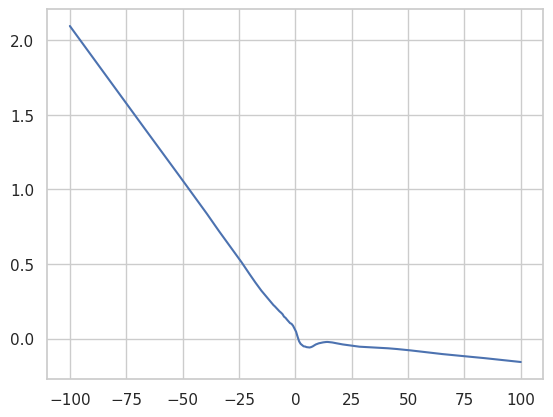

In [173]:
import matplotlib.pyplot as plt

# a_grid = a_grid.detach().squeeze()
qfunc = qfunc.detach().squeeze()

# plt.plot(a_grid[:, i_coord], qfunc)
plt.plot(s[:, i_coord], qfunc)

## word2vec embeddings

by given word predict another word with shared letters

### generate dataset

In [1]:
from environment.action import WordPairsDataset
from wordle.wordlenp import Wordle
import numpy as np

vocabulary = Wordle._load_vocabulary('wordle/guesses.txt', astype=np.array)
data = WordPairsDataset(vocabulary, 'word_pairs_dataset', generate=False)
len(data), data[1] 

(204834634, (0, 2))

### train

In [3]:
from environment.action import Embedding
import torch
from torch.utils.data import DataLoader


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

model = Embedding(embedding_size=6, vocab_size=len(vocabulary)).to(device)
optimizer = torch.optim.Adam(model.parameters())
model.load_state_dict(torch.load('embedding_model/4.pth'))

dataloader = DataLoader(
    dataset=data,
    batch_size=256,
    shuffle=True,
    num_workers=16
)

cuda:0


In [4]:
import os

path = 'embedding_model2'
os.mkdir(path)

n_epochs = 25
for i_epoch in range(n_epochs):
    model.train_epoch(dataloader, optimizer, device)
    torch.save(model.state_dict(), f'{path}/{i_epoch}.pth')

TRAIN BATCHES:   0%|          | 0/800136 [00:00<?, ?it/s]

TRAIN BATCHES:   0%|          | 0/800136 [00:00<?, ?it/s]

TRAIN BATCHES:   0%|          | 0/800136 [00:00<?, ?it/s]

TRAIN BATCHES:   0%|          | 0/800136 [00:00<?, ?it/s]

TRAIN BATCHES:   0%|          | 0/800136 [00:00<?, ?it/s]

TRAIN BATCHES:   0%|          | 0/800136 [00:00<?, ?it/s]

TRAIN BATCHES:   0%|          | 0/800136 [00:00<?, ?it/s]

TRAIN BATCHES:   0%|          | 0/800136 [00:00<?, ?it/s]

TRAIN BATCHES:   0%|          | 0/800136 [00:00<?, ?it/s]

TRAIN BATCHES:   0%|          | 0/800136 [00:00<?, ?it/s]

TRAIN BATCHES:   0%|          | 0/800136 [00:00<?, ?it/s]

TRAIN BATCHES:   0%|          | 0/800136 [00:00<?, ?it/s]

TRAIN BATCHES:   0%|          | 0/800136 [00:00<?, ?it/s]

TRAIN BATCHES:   0%|          | 0/800136 [00:00<?, ?it/s]

TRAIN BATCHES:   0%|          | 0/800136 [00:00<?, ?it/s]

TRAIN BATCHES:   0%|          | 0/800136 [00:00<?, ?it/s]

TRAIN BATCHES:   0%|          | 0/800136 [00:00<?, ?it/s]

TRAIN BATCHES:   0%|          | 0/800136 [00:00<?, ?it/s]

TRAIN BATCHES:   0%|          | 0/800136 [00:00<?, ?it/s]

TRAIN BATCHES:   0%|          | 0/800136 [00:00<?, ?it/s]

TRAIN BATCHES:   0%|          | 0/800136 [00:00<?, ?it/s]

TRAIN BATCHES:   0%|          | 0/800136 [00:00<?, ?it/s]

TRAIN BATCHES:   0%|          | 0/800136 [00:00<?, ?it/s]

TRAIN BATCHES:   0%|          | 0/800136 [00:00<?, ?it/s]

TRAIN BATCHES:   0%|          | 0/800136 [00:00<?, ?it/s]

### visualize

In [7]:
from environment.action import ActionEmbedding

i_word = 2313
metric_list = ['angular', 'euclidean', 'manhattan', 'hamming', 'dot']
for i_check in range(20,21):
    print(f'=== {i_check} ===')
    for metric in metric_list:
        indexer = ActionEmbedding(
            vocabulary, emb_size=6,
            metric=metric, model_path=f'embedding_model2/{i_check}.pth'
        ).indexer
        print(vocabulary[indexer.get_nns_by_item(i_word, 5)])

=== 20 ===
['zesty' 'keets' 'hesps' 'skegs' 'eughs']
['zesty' 'pechs' 'chems' 'mimes' 'speck']
['zesty' 'pechs' 'chems' 'kypes' 'shies']
['aside' 'crisp' 'drawl' 'dying' 'flute']
['jnana' 'bobby' 'jujus' 'tizzy' 'wojus']


In [8]:
from sklearn.manifold import TSNE
import plotly.graph_objects as go
import pandas as pd
from environment.action import Embedding
import torch


vocab = Wordle._load_vocabulary('wordle/guesses.txt', astype=np.array)
model = Embedding(6, len(vocab))
model.load_state_dict(torch.load('embedding_model2/24.pth'))
table = model.get_table()


# get embeddings
embeddings_df = pd.DataFrame(table)

# t-SNE transform
tsne = TSNE(n_components=2)
embeddings_df_trans = tsne.fit_transform(embeddings_df)
embeddings_df_trans = pd.DataFrame(embeddings_df_trans)

In [9]:
embeddings_df_trans['word'] = vocab

In [10]:
fig = go.Figure()

df = embeddings_df_trans.sample(12972)

fig.add_trace(
    go.Scatter(
        x=df[0],
        y=df[1],
        mode="text",
        text=df['word'],
        textposition="middle center"
    )
)
# fig.write_html("../word2vec_visualization.html")

In [26]:
ind = vocab.searchsorted('zesty')-1
vocab[ind]

'zests'

In [34]:
vocab[ind+2]

'zexes'

In [31]:
indexer = ActionEmbedding(
    vocabulary, emb_size=6,
    metric='euclidean', model_path=f'embedding_model/{4}.pth'
).indexer
vec = table[2313]-table[ind]+table[ind+1]
print(vocabulary[indexer.get_nns_by_vector(vec, 5)])

['stale' 'anise' 'teals' 'stela' 'aisle']


In [20]:
vocab[2313]

'zesty'

# LETS GO

In [82]:
%load_ext autoreload
%autoreload 2

from collections import defaultdict
import pickle

from wordle.wordlenp import Wordle
from environment.environment import Environment, StateYesNo, StateVocabulary
from environment.action import ActionEmbedding, ActionLetters
from dqn.agent import Agent
from dqn.train import Trainer
from replay_buffer.cpprb import PrioritizedReplayBuffer, ReplayBuffer

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
import torch
import numpy as np
np.random.seed(0)

"cuda:0" if torch.cuda.is_available() else "cpu"

'cpu'

In [83]:
word_list = Wordle._load_vocabulary('wordle/guesses.txt', astype=np.array)

def make_data(n_answers, n_guesses):
    guesses = np.random.choice(word_list, size=n_guesses, replace=False)
    answers = np.random.choice(guesses, size=n_answers, replace=False)
    return answers, guesses

answers_10_100, guesses_10_100 = make_data(10, 100)
answers_100_100, guesses_100_100 = make_data(100, 100)
step_rewards = {'B':0, 'Y':1, 'G':1, 'win':10, 'lose':-10, 'step':-5}
tasks_results = defaultdict(dict)

In [114]:
def experiment(answers, guesses, n_batches, n_batches_warm):
    env_list = []
    for _ in range(8):
        env = Environment(
            rewards=step_rewards,
            wordle=Wordle(vocabulary=guesses, answers=answers),
            state_instance=StateYesNo()
        )
        env_list.append(env)

    agent = Agent(
        state_size=env.state.size,
        action_instance=ActionEmbedding(vocabulary=guesses, emb_size=10),
        replay_buffer=ReplayBuffer(state_size=env.state.size),
        optimize_interval=8
    )

    trainer = Trainer(
        env_list, agent,
        n_batches=n_batches,
        n_batches_warm=n_batches_warm,
    )
    
    res = trainer.train(eps_decay=0.99, eps_start=0, eps_end=0, nickname=f'embtest-{len(answers)}-{len(guesses)}')
    return agent.qnetwork_local

In [139]:
model = experiment(
    answers_10_100, guesses_10_100,
    n_batches=8, n_batches_warm=8,
)

WARM BATCHES:   0%|          | 0/8 [00:00<?, ?it/s]

TRAIN BATCHES:   0%|          | 0/8 [00:00<?, ?it/s]

/home/ilya/repos/wordle-rl/dqn/train.py:342: RuntimeWarning: Mean of empty slice.
  mean_steps = steps[success.astype(bool)].mean()
/home/ilya/.local/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



Batch    1	Time: 10 s	Agent Eps: 0.00	Train Win Rate: 0.00%	Test Win Rate: 0.00%	Test Mean Steps: nan

Batch    2	Time: 21 s	Agent Eps: 0.00	Train Win Rate: 0.00%	Test Win Rate: 0.00%	Test Mean Steps: nan

Batch    3	Time: 32 s	Agent Eps: 0.00	Train Win Rate: 0.00%	Test Win Rate: 0.00%	Test Mean Steps: nan

Batch    4	Time: 42 s	Agent Eps: 0.00	Train Win Rate: 0.00%	Test Win Rate: 0.00%	Test Mean Steps: nan

Batch    5	Time: 52 s	Agent Eps: 0.00	Train Win Rate: 0.00%	Test Win Rate: 0.00%	Test Mean Steps: nan

Batch    6	Time: 63 s	Agent Eps: 0.00	Train Win Rate: 0.00%	Test Win Rate: 0.00%	Test Mean Steps: nan

Batch    7	Time: 75 s	Agent Eps: 0.00	Train Win Rate: 0.00%	Test Win Rate: 0.00%	Test Mean Steps: nan

Batch    8	Time: 85 s	Agent Eps: 0.00	Train Win Rate: 0.00%	Test Win Rate: 0.00%	Test Mean Steps: nan

Saving checkpoint... Saved to embtest-10-100-1.pth


In [140]:
import torch

n_samples = 300
state_size = model.state_size
emb_size = model.emb_size
n_samples = 300

s_same = torch.tile(torch.randn(1, state_size), dims=[n_samples, 1])
a_grid = torch.tile(torch.randn(1, emb_size), dims=[n_samples, 1])

In [141]:
i_coord = 0
left = -10
right = 10

a_grid[:, i_coord] = torch.linspace(left, right, n_samples)
qfunc, a = model.forward(s_same, a_grid * 100)

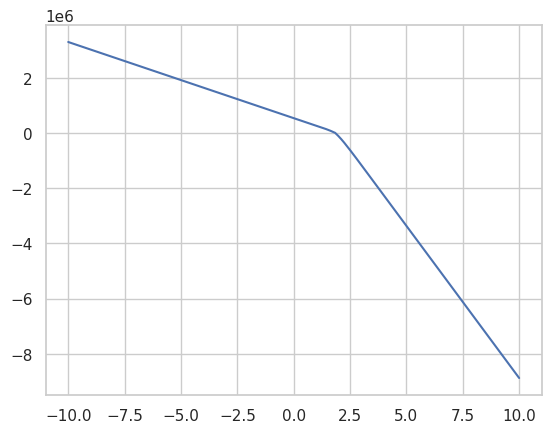

In [142]:
import matplotlib.pyplot as plt

a_grid = a_grid.detach().squeeze()
qfunc = qfunc.detach().squeeze()

plt.plot(a_grid[:, i_coord], qfunc)